# User Interface of the assignment of Research Track 2 #

Before starting to use this user interface, please run:
```console
$ roslaunch rt2_assignment jupyter_ass.launch
```

## imports ##

In [1]:
import rospy
import jupyros as jr 
import ipywidgets as widgets
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from jupyros import ros3d
from ipywidgets import interactive_output
from geometry_msgs.msg import Twist
from rt2_assignment.srv import Command
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from matplotlib.animation import FuncAnimation

# Import the autonomous_driving class of the package.
sys.path.append("../scripts/")
import autonomous_driving

## Initialization of the ROS node ##

In [2]:
# If ui is set to None, the autonomous_driving class does not print anything.
ui = None
rospy.init_node('driving_mode')                    # Initialize the ROS node.
ad = autonomous_driving.autonomous_driving(ui)     # Initialize the clas for autonomously drive the robot.
client = rospy.ServiceProxy("/command", Command)   # Initialize the client for the driver_assistance node.
rospy.wait_for_service("/command")                 # Waits until the driver_assistance node is ready.
publisher = jr.publish('/cmd_vel', Twist)          # Initialize a publisher to the cmd_vel topic.

## Definition of widgets ##

In [3]:
# This widget displays the three driving modalities.
driving_mode = widgets.ToggleButtons(
    options=[('Autonomous driving', 1), ('Free drive', 2), ('Driver assistance', 3)],
    description='Choose:',
    value=1,
    disabled=False,
    button_style='',
)

# This widget asks for the x goal.
x_goal = widgets.FloatText(
    value=0,
    description='x goal:',
    disabled=False,
)

# This widget asks for the y goal.
y_goal = widgets.FloatText(
    value=0,
    description='y goal:',
    disabled=False,
)

# This widget shows the possible commands for the driver_assistance node.
driver_assistance = widgets.ToggleButtons(
    options=[('Increase speed', 'w'), ('Decrease speed', 's'), ('Turn left', 'a'), ('Turn right', 'd'),
             ('Stop linear', 'x'), ('Stop angular', 'z'), ('Stop sending', '0')],
    value='0',
    disabled=False,
    button_style='',
)

# This widget can change the zoom value for the laser scanner graphic.
zoom_slider = widgets.FloatSlider(
    value=1.0,
    min=1.0,
    max=20.0,
    step=0.1,
    description='Zoom:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

## User Interface ##

### Choose one of the following driving modalities: ###

In [4]:
display(driving_mode)

ToggleButtons(description='Choose:', options=(('Autonomous driving', 1), ('Free drive', 2), ('Driver assistanc…

### Drive the robot! ###

In [5]:
def ask_server(req):
    # Function binded with the driver_assistance widget to ask the server with the proper command.
    client(ord(req))
    

def choice(mode):
    # Function binded with the driving_mode widget.
    # It shows the proper user interface for different driving modalities.
    
    # If the autonomous driving is processing a goal, send  cancel request.
    if ad.is_active is True:
        ad.cancel_goal()
    
    if mode == 1:        ### Autonomous driving mode selected. ###
        
        ask_server('1')   # Disable the driver_assistance node.
        display(x_goal)
        display(y_goal)
        interactive_output(ad.reach_goal, {'x': x_goal, 'y': y_goal})   # Ask the autonomous_driving to reach the goal.

    if mode == 2:        ### Free drive mode selected. ###
        
        ask_server('1')   # Disable the driver_assistance node.
        display(publisher)
        
    if mode == 3:        ### Driver assistance mode selected. ###
        
        ask_server('0')   # Enable the driver_assistance node.
        display(driver_assistance)
        
interactive_output(ask_server, {'req': driver_assistance})
interactive_output(choice, {'mode': driving_mode})

Output()

### This is what the robot can see: ###

In [6]:
v = ros3d.Viewer()
rc = ros3d.ROSConnection(url="ws://localhost:9090") 
tf_client = ros3d.TFClient(ros=rc, fixed_frame='map')
laser_view = ros3d.LaserScan(topic="/scan", ros=rc, tf_client=tf_client) 
map_view = ros3d.OccupancyGrid(topic="/map", ros=rc, tf_client=tf_client, continuous=True) 
path = ros3d.Path(topic="/move_base/NavfnROS/plan", ros=rc, tf_client=tf_client) 
urdf = ros3d.URDFModel(ros=rc, tf_client=tf_client, path=os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000')) 
g = ros3d.GridModel()
v.objects = [g, laser_view, map_view, path, urdf]
v

Viewer(objects=[GridModel(), LaserScan(ros=ROSConnection(url='ws://localhost:9090'), tf_client=TFClient(fixed_…

In [7]:
class Visualiser:
    
    def __init__(self):
        self.fig = plt.figure(figsize=(10,5))
        
        self.ax_laser = plt.subplot(2, 2, (1, 2), projection='polar')   
        self.ax_odom = plt.subplot(2, 2, 3)
        #self.ax_count = plt.subplot(2, 2, 4)
        
        self.ln_laser, = self.ax_laser.plot([], [], 'r.') 
        self.laser_r, self.laser_theta = [], []
        self.laser_rmax = 21
        
        self.ln_odom, = self.ax_odom.plot([], [], 'ro') 
        self.odom_x, self.odom_y = [] , []
        
        #self.ln_count = self.ax_count.hist(1,1)
        #self.count = []
        
    def plot_init(self):
        self.ax_laser.set_thetalim(-np.pi/2, np.pi/2)
        self.ax_laser.set_rmax(self.laser_rmax)
        self.ax_laser.set_theta_zero_location("N")
        
        self.ax_odom.set_xlim(-10, 10) 
        self.ax_odom.set_ylim(-10, 10)
        
        return (self.ln_laser, self.ln_odom)
    
    def scanner_callback(self, msg):
        self.laser_r = msg.ranges
        self.laser_theta = np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment)
        
    def odom_callback(self, msg): 
        self.odom_x.append(msg.pose.pose.position.y)
        self.odom_y.append(msg.pose.pose.position.x)
        
    #def count_callback(self, msg):
        #self.count.append(1)
        
    def update_plot(self, frame):
        #for artist in ax_laser.gca().lines + ax_laser.gca().collections:
            #artist.remove()
            
        self.ln_laser = ax_laser.plot(self.laser_theta, self.laser_r, 'r.')
        self.ax_laser.set_rmax(self.laser_rmax)
        
        self.ln_laser.set_data(self.laser_theta, self.laser_r)
        # self.ln_count.set_data(self.count)  

        return (self.ln_odom, self.ln_laser)
    
    def zoom(self, zoom):
        self.laser_rmax = 21 - zoom

<IPython.core.display.Javascript object>


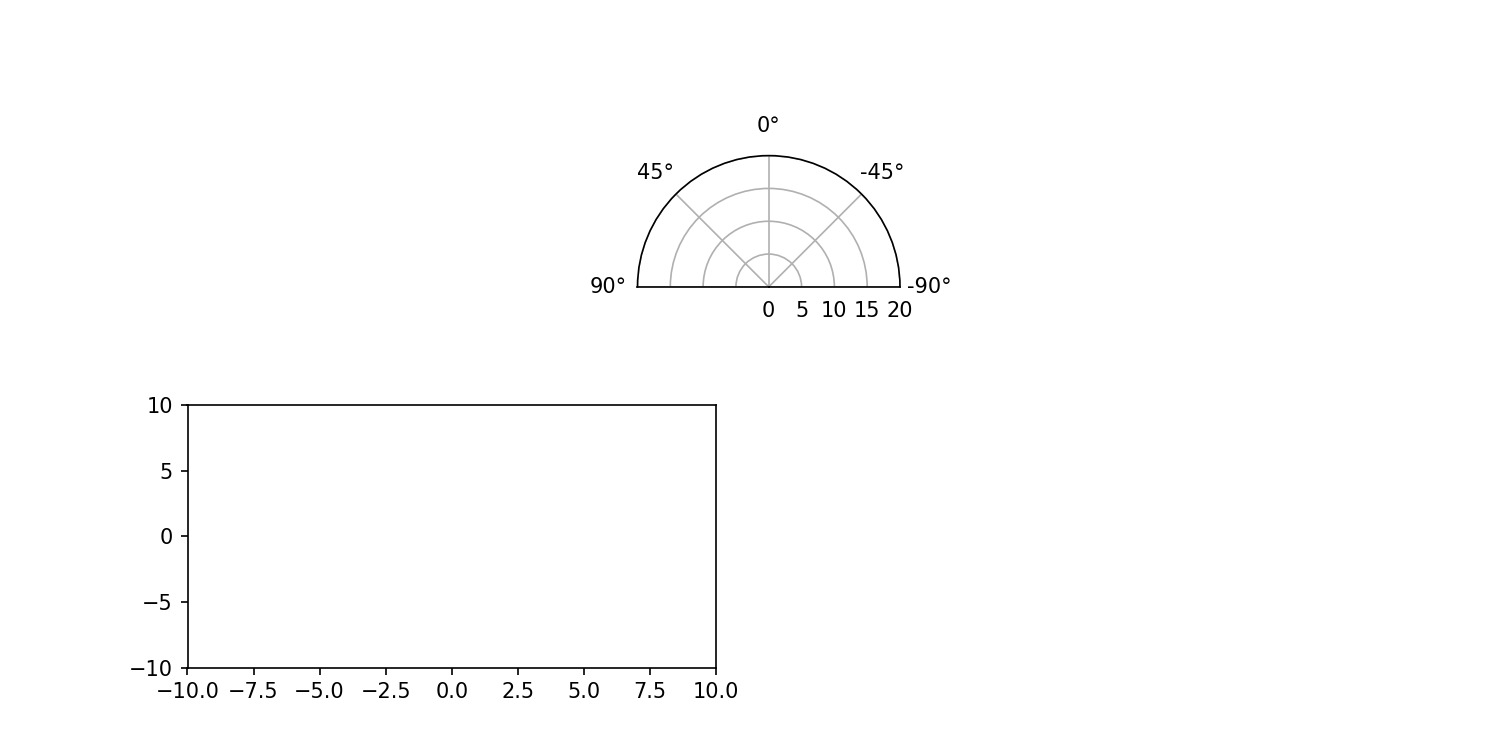

In [8]:
%matplotlib notebook

vis = Visualiser()

sub_odom = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
sub_laser = rospy.Subscriber('/scan', LaserScan, vis.scanner_callback)

ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init, frames=100, interval=20, blit=True)

plt.show()

In [9]:
class VisualiserScanner:
    
    def __init__(self):
        self.fig, self.ax = plt.subplots(subplot_kw={'projection': 'polar'})
        self.ln, = plt.plot([], [], 'r.') 
        self.r, self.theta = [], []
        self.rmax = 10
        
    def plot_init(self):
        self.ax.set_thetalim(-np.pi/2, np.pi/2)
        self.ax.set_rmax(self.rmax)
        self.ax.set_theta_zero_location("N")
        return self.ln
        
    def scanner_callback(self, msg):
        self.r = msg.ranges
        self.theta = np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment)
        
    def update_plot(self, frame):
        for artist in plt.gca().lines + plt.gca().collections:
            artist.remove()
            
        self.ln = plt.plot(self.theta, self.r, 'r.')
        self.ax.set_rmax(self.rmax)
        
        return self.ln
    
    def zoom(self, zoom):
        self.rmax = zoom

In [10]:
interactive_output(vis.zoom, {'zoom': zoom_slider})
display(zoom_slider)

FloatSlider(value=1.0, continuous_update=False, description='Zoom:', max=20.0, min=1.0, readout_format='.1f')